In [1]:
import utils
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

## Wizualizacja dla jednego przypadku participant 3, 40 cm, trail 1

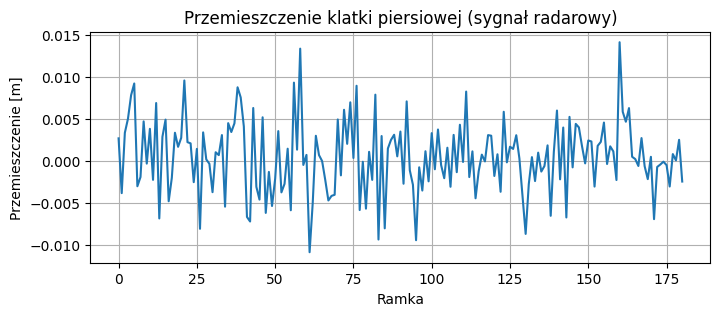

In [2]:
BASE_PATH = Path(
    "/Users/paulinawor/Documents/magisterka/Participant 3/1. Distance Scenario"
)
d = 40
t = "1"
bin_path = BASE_PATH / f"{d} cm" / t / "data_Raw_0.bin"

iq = utils.load_radar_bin(bin_path)

range_mag = utils.compute_range_profile(iq)
chest_bin = utils.select_chest_bin(range_mag)

phase = utils.extract_phase(iq, chest_bin)
displacement = utils.phase_to_displacement(phase)

plt.figure(figsize=(8,3))
plt.plot(displacement)
plt.title("Przemieszczenie klatki piersiowej (sygnał radarowy)")
plt.xlabel("Ramka")
plt.ylabel("Przemieszczenie [m]")
plt.grid(True)
plt.show()

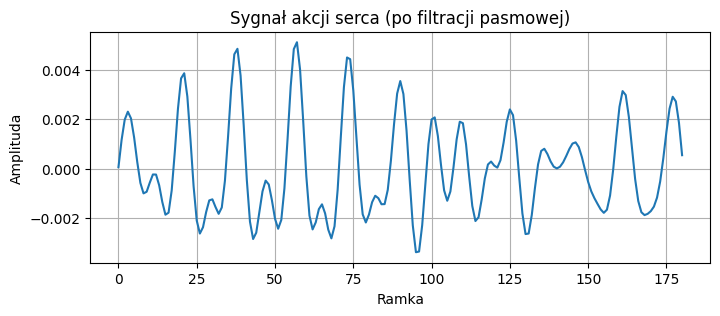

In [3]:
FS = 20.0
heart = utils.bandpass(displacement, FS, 0.8, 2.5)
plt.figure(figsize=(8,3))
plt.plot(heart)
plt.title("Sygnał akcji serca (po filtracji pasmowej)")
plt.xlabel("Ramka")
plt.ylabel("Amplituda")
plt.grid(True)
plt.show()

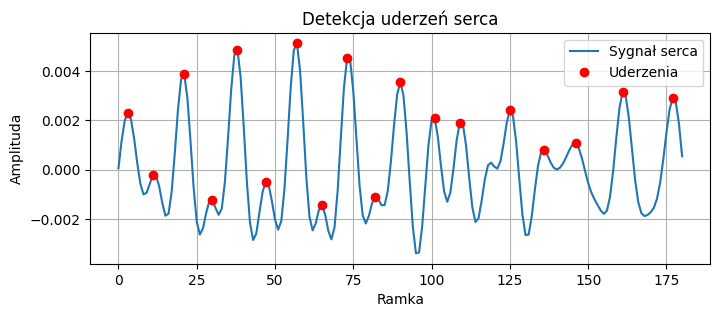

In [4]:
peaks, _ = find_peaks(
    heart,
    distance=int(FS * 0.4)
)
plt.figure(figsize=(8,3))
plt.plot(heart, label="Sygnał serca")
plt.plot(peaks, heart[peaks], "ro", label="Uderzenia")
plt.title("Detekcja uderzeń serca")
plt.xlabel("Ramka")
plt.ylabel("Amplituda")
plt.legend()
plt.grid(True)
plt.show()

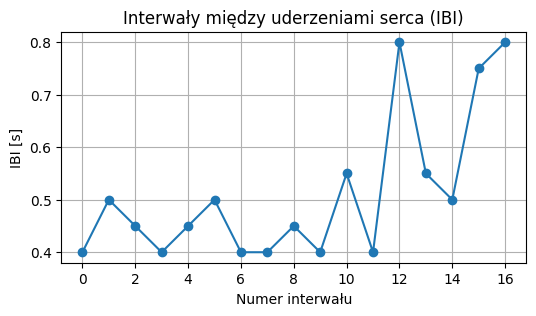

In [5]:
peak_times = peaks / FS
ibi = np.diff(peak_times)
plt.figure(figsize=(6,3))
plt.plot(ibi, marker="o")
plt.title("Interwały między uderzeniami serca (IBI)")
plt.xlabel("Numer interwału")
plt.ylabel("IBI [s]")
plt.grid(True)
plt.show()

## Jak detekcja HRV się zmienia w zalezności od odległości 

### Wczytanie danych dla odległości dla uczestnika 3 

In [6]:
BASE_PATH = Path(
    "/Users/paulinawor/Documents/magisterka/Participant 3/1. Distance Scenario"
)

distances = ["40 cm", "80 cm", "120 cm", "160 cm"]
trials = ["1", "2", "3", "4"]

results_hrv = []

for d in distances:
    for t in trials:
        bin_path = BASE_PATH / d / t / "data_Raw_0.bin"
        if not bin_path.exists():
            continue

        hrv = utils.process_one_measurement(bin_path)
        if hrv is None:
            continue

        hrv.update({
            "distance_cm": int(d.split()[0]),
            "trial": int(t)
        })

        results_hrv.append(hrv)

### Metryki:
* num_beats - liczba wykrytych uderzeń serca (liczba interwałów)
* mean_ibi - średni czas między uderzeniami serca
* SDNN - miara ogólnej zmienności rytmu serca
* RMSSD - krótkoterminowa zmienność

(Dla kazdej odległości 40, 80, 120 i 160 cm bierzemy 4 próby i liczymy średnią wartość i odchylenie standardowe.)

In [7]:
df_hrv = pd.DataFrame(results_hrv)

summary = df_hrv.groupby("distance_cm").agg(["mean", "std"])
summary

num_beats            mean_ibi                sdnn            \
                 mean       std      mean       std      mean       std   
distance_cm                                                               
40               13.5  2.645751  0.626656  0.102594  0.195543  0.074837   
80               13.0  0.816497  0.644746  0.053890  0.183710  0.072139   
120              13.0  0.816497  0.638416  0.064307  0.176501  0.031511   
160              13.5  0.577350  0.636126  0.029488  0.175295  0.028029   

                rmssd           trial            
                 mean       std  mean       std  
distance_cm                                      
40           0.259923  0.131210   2.5  1.290994  
80           0.242294  0.101943   2.5  1.290994  
120          0.259964  0.045036   2.5  1.290994  
160          0.218112  0.065326   2.5  1.290994

Wniosek: 
* przy większej odległości jest lepsza detekcja uderzeń serca
* radar poprawnie śledzi rytm serca, a stabilność estymacji rośnie z odległością

Średnia SDNN lekko maleje wraz z odległością

ODCHYLENIE STANDARDOWE WYRAŹNIE MALEJE

To oznacza:
* przy 40–80 cm: duża niestabilność estymacji
* przy 120–160 cm: bardziej powtarzalna detekcja HRV

Dla RMSSD tak samo jak dla SDNN.

Wraz ze wzrostem odległości pomiaru obserwowana jest wyraźna poprawa stabilności estymacji parametrów HRV, co przejawia się istotnym spadkiem odchylenia standardowego SDNN, RMSSD oraz liczby wykrytych uderzeń serca.

## Dalsza analiza

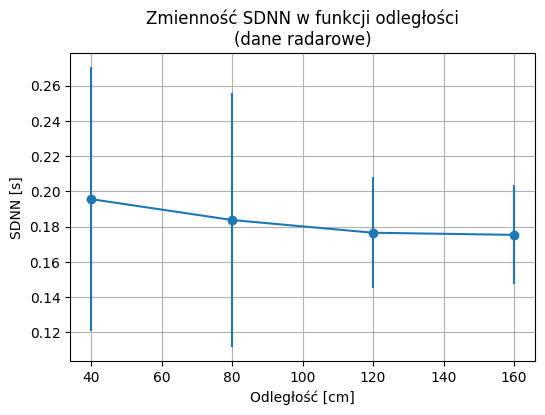

In [8]:
plt.figure(figsize=(6,4))
plt.errorbar(
    summary.index,
    summary["sdnn"]["mean"],
    yerr=summary["sdnn"]["std"],
    fmt="o-"
)
plt.xlabel("Odległość [cm]")
plt.ylabel("SDNN [s]")
plt.title("Zmienność SDNN w funkcji odległości\n(dane radarowe)")
plt.grid(True)
plt.show()

Mnijesze SDNN oznacza bardziej regularny rytm, a większe SDNN większą zmienność rytmu serca.

Z wykresu wnioskujemy: im większa odległość tym mniejsze odchylenie standardowe, czyli bardziej stabilna detekcja HRV
Przy małej odległości radar „widzi za dużo”, sygnał jest niestabilny, natomiast przy większej odległości sygnał jest spokojniejszy i bardziej powtarzalny.

## Wpółczynnik zmienności cv dla sdnn

In [9]:
cv_sdnn = summary["sdnn"]["std"] / summary["sdnn"]["mean"]
print(cv_sdnn)

distance_cm
40     0.382713
80     0.392680
120    0.178533
160    0.159897
dtype: float64


dla 40-80 cm bardzo wysoka zmieność i niska powtarzalność, dla 120-160 2 razy mniejsza zmnienność i dobra powtarzalość

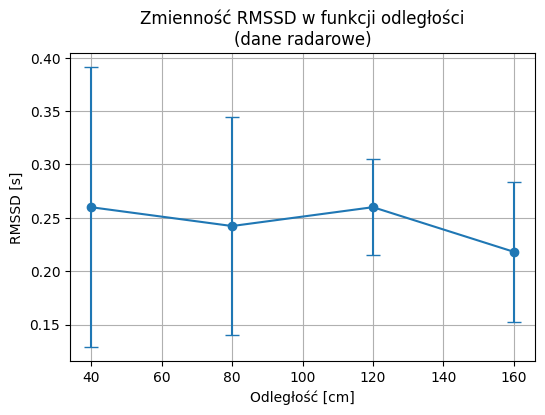

In [10]:
plt.figure(figsize=(6,4))

plt.errorbar(
    summary.index,
    summary["rmssd"]["mean"],
    yerr=summary["rmssd"]["std"],
    fmt="o-",
    capsize=5
)

plt.xlabel("Odległość [cm]")
plt.ylabel("RMSSD [s]")
plt.title("Zmienność RMSSD w funkcji odległości\n(dane radarowe)")
plt.grid(True)

plt.show()

Radar wykrywa podobny poziom krótkoterminowej HRV, ale przy większych odległościach robi to bardziej stabilnie i powtarzalnie. Wraz ze wzrostem odległości, maleje zmienność wyników między próbami

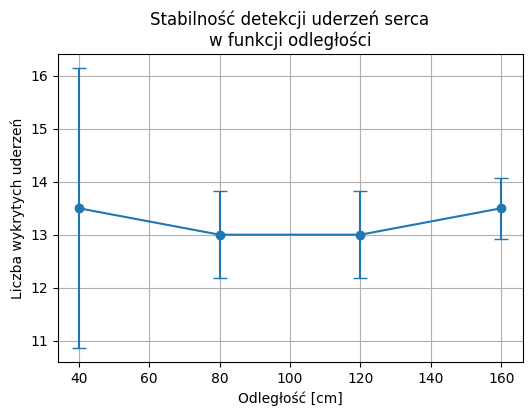

In [11]:
plt.figure(figsize=(6,4))

plt.errorbar(
    summary.index,
    summary["num_beats"]["mean"],
    yerr=summary["num_beats"]["std"],
    fmt="o-",
    capsize=5
)

plt.xlabel("Odległość [cm]")
plt.ylabel("Liczba wykrytych uderzeń")
plt.title("Stabilność detekcji uderzeń serca\nw funkcji odległości")
plt.grid(True)
plt.show()

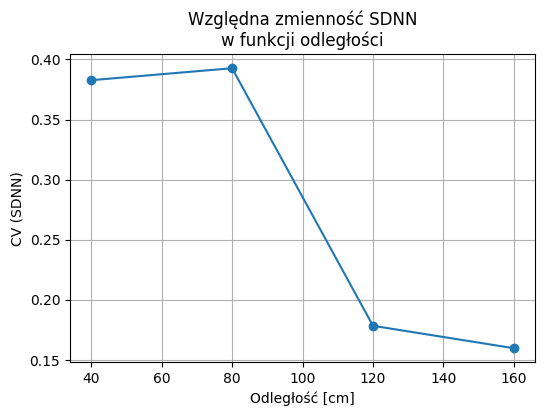

In [12]:
cv_sdnn = summary["sdnn"]["std"] / summary["sdnn"]["mean"]

plt.figure(figsize=(6,4))
plt.plot(cv_sdnn.index, cv_sdnn.values, "o-")

plt.xlabel("Odległość [cm]")
plt.ylabel("CV (SDNN)")
plt.title("Względna zmienność SDNN\nw funkcji odległości")
plt.grid(True)
plt.show()

/var/folders/6x/9m2vth756wd0n_2nmdn4lt0h0000gn/T/ipykernel_78542/1406799730.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df_hrv["distance_cm"].unique()))


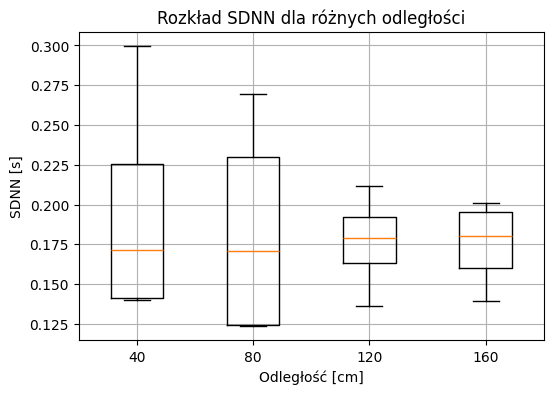

In [13]:
plt.figure(figsize=(6,4))

data = [
    df_hrv[df_hrv["distance_cm"] == d]["sdnn"]
    for d in sorted(df_hrv["distance_cm"].unique())
]

plt.boxplot(data, labels=sorted(df_hrv["distance_cm"].unique()))

plt.xlabel("Odległość [cm]")
plt.ylabel("SDNN [s]")
plt.title("Rozkład SDNN dla różnych odległości")
plt.grid(True)
plt.show()

/var/folders/6x/9m2vth756wd0n_2nmdn4lt0h0000gn/T/ipykernel_78542/2097401250.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=sorted(df_hrv["distance_cm"].unique()))


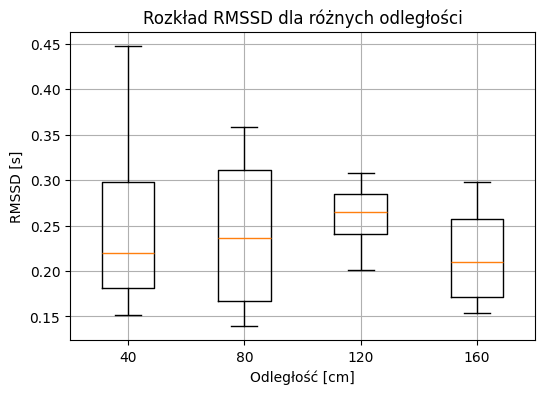

In [14]:
plt.figure(figsize=(6,4))

data = [
    df_hrv[df_hrv["distance_cm"] == d]["rmssd"]
    for d in sorted(df_hrv["distance_cm"].unique())
]

plt.boxplot(data, labels=sorted(df_hrv["distance_cm"].unique()))

plt.xlabel("Odległość [cm]")
plt.ylabel("RMSSD [s]")
plt.title("Rozkład RMSSD dla różnych odległości")
plt.grid(True)
plt.show()

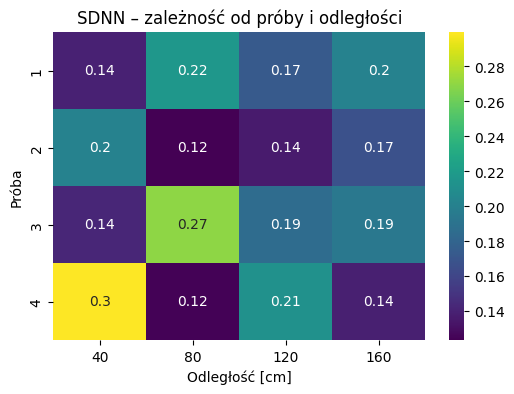

In [15]:
import seaborn as sns

pivot = df_hrv.pivot(
    index="trial",
    columns="distance_cm",
    values="sdnn"
)

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap="viridis")

plt.title("SDNN – zależność od próby i odległości")
plt.xlabel("Odległość [cm]")
plt.ylabel("Próba")
plt.show()

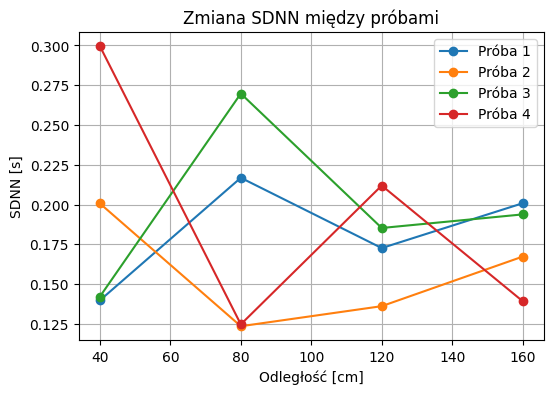

In [16]:
plt.figure(figsize=(6,4))
for t in sorted(df_hrv["trial"].unique()):
    subset = df_hrv[df_hrv["trial"] == t]
    plt.plot(
        subset["distance_cm"],
        subset["sdnn"],
        "o-",
        label=f"Próba {t}"
    )

plt.xlabel("Odległość [cm]")
plt.ylabel("SDNN [s]")
plt.title("Zmiana SDNN między próbami")
plt.legend()
plt.grid(True)
plt.show()

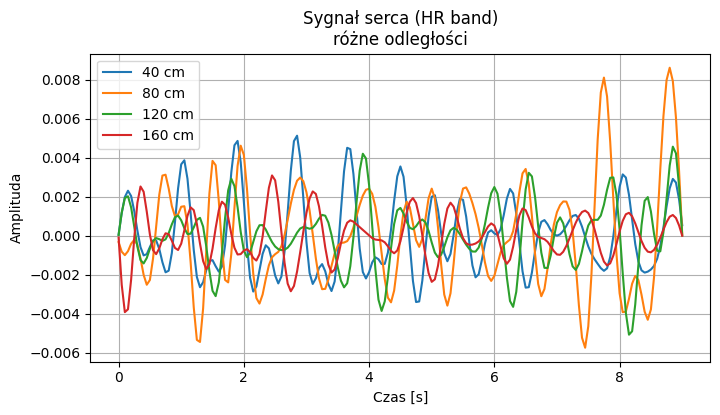

In [17]:
plt.figure(figsize=(8,4))

for d in [40, 80, 120, 160]:
    bin_path = BASE_PATH / f"{d} cm" / "1" / "data_Raw_0.bin"

    iq = utils.load_radar_bin(bin_path)
    range_mag = utils.compute_range_profile(iq)
    chest_bin = utils.select_chest_bin(range_mag)

    phase = utils.extract_phase(iq, chest_bin)
    displacement = utils.phase_to_displacement(phase)

    hr_signal = utils.bandpass(displacement, FS, 0.8, 2.5)

    t = np.arange(len(hr_signal)) / FS
    plt.plot(t, hr_signal, label=f"{d} cm")

plt.xlabel("Czas [s]")
plt.ylabel("Amplituda")
plt.title("Sygnał serca (HR band)\nróżne odległości")
plt.legend()
plt.grid(True)
plt.show()

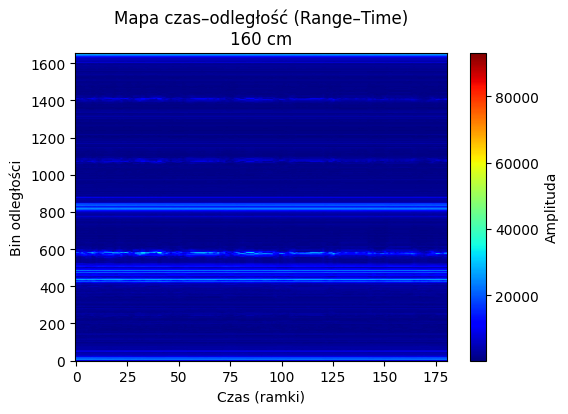

In [18]:
d = 160
bin_path = BASE_PATH / f"{d} cm" / "1" / "data_Raw_0.bin"

iq = utils.load_radar_bin(bin_path)

range_mag = utils.compute_range_profile(iq, rx_id=0)

range_map = range_mag.mean(axis=1)   

plt.figure(figsize=(6,4))
plt.imshow(
    range_map.T,
    aspect="auto",
    origin="lower",
    cmap="jet"
)

plt.xlabel("Czas (ramki)")
plt.ylabel("Bin odległości")
plt.title(f"Mapa czas–odległość (Range–Time)\n{d} cm")
plt.colorbar(label="Amplituda")
plt.show()

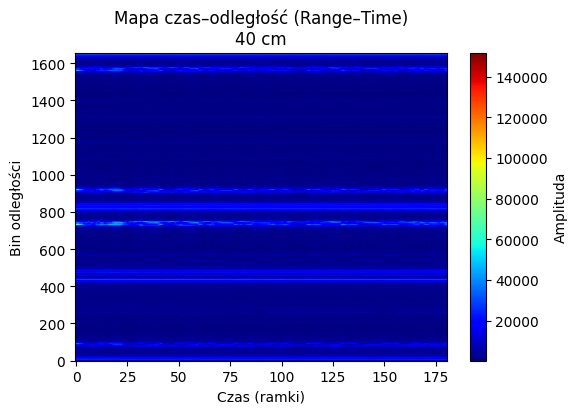

In [19]:
d = 40
bin_path = BASE_PATH / f"{d} cm" / "1" / "data_Raw_0.bin"

iq = utils.load_radar_bin(bin_path)

range_mag = utils.compute_range_profile(iq, rx_id=0)

range_map = range_mag.mean(axis=1)   

plt.figure(figsize=(6,4))
plt.imshow(
    range_map.T,
    aspect="auto",
    origin="lower",
    cmap="jet"
)

plt.xlabel("Czas (ramki)")
plt.ylabel("Bin odległości")
plt.title(f"Mapa czas–odległość (Range–Time)\n{d} cm")
plt.colorbar(label="Amplituda")
plt.show()